In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install transformers
!pip install sentencepiece


     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 35.2 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 16.9 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [18]:
import pandas as pd
train_data =pd.read_csv("/content/drive/MyDrive/FMNLP_HW3/WD/train.csv")
validation =pd.read_csv("/content/drive/MyDrive/FMNLP_HW3/WD/dev.csv")
test =pd.read_csv("/content/drive/MyDrive/FMNLP_HW3/WD/test.csv")
train_data

,text,label
0,Redemption round ( thank goodness ) and home m...,0
1,Who are these people LOL mkr,0
2,Oh no no no it's a conspiracy. mkr,0
3,Vicky and Celine kickass I hope they do mkr,0
4,A lot of people would like to put Kat to sudde...,0
...,...,...
3099,countdown to more companies following suit aft...,0
3100,"So, just to save you all some time, BSD is my ...",0
3101,or so I can direct parents there around xmas t...,0
3102,@User @User I agree 100% with this statement.,0


In [19]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [21]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = list(df['label'])
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 64, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [22]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

def tensor_to_onehot(tensor_file):
  temp = list()
  for i in tensor_file.tolist():
    if i ==0:
      temp.append([1,0])
    else:
      temp.append([0,1])

  return torch.tensor(temp)



In [69]:
from torch.optim import Adam
from tqdm import tqdm

from transformers import AdamW, get_linear_schedule_with_warmup


def train(model, train_data, val_data, learning_rate, epochs):


    train_loss_list = []
    val_loss_list =[]
    train_acc_list = []
    val_acc_list = []
    val_f1score_list = []

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss(reduction='sum',pos_weight=torch.tensor(1902/1202))
    optimizer = AdamW(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                # print("train label",train_label,"\n")
                # target = torch.nn.functional.one_hot(train_label)
                target = tensor_to_onehot(train_label)
                # print("target",target,"\n outpur",output)
                target = target.to(device)
                batch_loss = criterion(output, target.float())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            total_f1score_val = 0 
            counter = 0
            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    counter+=1
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)



                    target_val = tensor_to_onehot(val_label)
                    target_val = target_val.to(device)
                    batch_loss = criterion(output, target_val.float())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    total_f1score_val += f1_score(val_label.tolist(), output.argmax(dim=1).tolist(), average='macro')
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}\
                | Val F1_score:{total_f1score_val/counter : .3f}')
            train_loss_list.append(total_loss_train / len(train_data))
            val_loss_list.append(total_loss_val / len(val_data))
            train_acc_list.append(total_acc_train / len(train_data))
            val_acc_list.append(total_acc_val / len(val_data))
            val_f1score_list.append(total_f1score_val/counter)

    return train_loss_list,val_loss_list,train_acc_list,val_acc_list,val_f1score_list           
                  
EPOCHS = 8
model = BertClassifier()
LR = 1e-6
# LR = 1e-4
              
train_loss_list,val_loss_list,train_acc_list,val_acc_list,val_f1score_list=train(model, train_data, validation, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 388/388 [01:27<00:00,  4.43it/s]


Epochs: 1 | Train Loss:  1.657                 | Train Accuracy:  0.620                 | Val Loss:  1.524                 | Val Accuracy:  0.700                | Val F1_score: 0.544


100%|██████████| 388/388 [01:27<00:00,  4.43it/s]


Epochs: 2 | Train Loss:  1.448                 | Train Accuracy:  0.756                 | Val Loss:  1.349                 | Val Accuracy:  0.786                | Val F1_score: 0.645


100%|██████████| 388/388 [01:27<00:00,  4.43it/s]


Epochs: 3 | Train Loss:  1.317                 | Train Accuracy:  0.799                 | Val Loss:  1.261                 | Val Accuracy:  0.795                | Val F1_score: 0.665


100%|██████████| 388/388 [01:27<00:00,  4.44it/s]


Epochs: 4 | Train Loss:  1.214                 | Train Accuracy:  0.833                 | Val Loss:  1.177                 | Val Accuracy:  0.847                | Val F1_score: 0.726


100%|██████████| 388/388 [01:27<00:00,  4.44it/s]


Epochs: 5 | Train Loss:  1.133                 | Train Accuracy:  0.862                 | Val Loss:  1.150                 | Val Accuracy:  0.851                | Val F1_score: 0.746


100%|██████████| 388/388 [01:27<00:00,  4.44it/s]


Epochs: 6 | Train Loss:  1.064                 | Train Accuracy:  0.897                 | Val Loss:  1.115                 | Val Accuracy:  0.869                | Val F1_score: 0.787


100%|██████████| 388/388 [01:27<00:00,  4.44it/s]


Epochs: 7 | Train Loss:  1.014                 | Train Accuracy:  0.916                 | Val Loss:  1.111                 | Val Accuracy:  0.876                | Val F1_score: 0.789


100%|██████████| 388/388 [01:27<00:00,  4.44it/s]


Epochs: 8 | Train Loss:  0.962                 | Train Accuracy:  0.934                 | Val Loss:  1.112                 | Val Accuracy:  0.868                | Val F1_score: 0.791


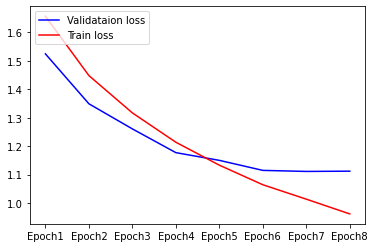

In [80]:
import numpy as np
import matplotlib.pyplot as plt



x = ['Epoch' + str(i+1) for i in range(8)]


plt.plot(x, val_loss_list, "-b", label="Validataion loss")
plt.plot(x, train_loss_list, "-r", label="Train loss")

plt.legend(loc="upper left")
plt.show()
# plt.ylim(0, 2.0)


In [2]:
import numpy as np
import matplotlib.pyplot as plt



x = ['Epoch' + str(i+1) for i in range(8)]


plt.plot(x, train_acc_list, "-b*", label="Train accuracy")
plt.plot(x, val_acc_list, "-r+", label="Validataion  accuracy")

plt.legend(loc="upper left")
plt.show()

In [89]:

from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support



def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=835)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    total_f1score_test = 0 
    counter = 0 
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
              counter +=1
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              # print(total_f1score_test,len(test_data))
              total_f1score_test += f1_score(test_label.tolist(), output.argmax(dim=1).tolist(), average='macro')
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              all_meausure = []

              for i in range(3):
                temp = list(precision_recall_fscore_support(test_label.tolist(), output.argmax(dim=1).tolist(), average=None,labels=[0,1]))[i]
                all_meausure.append(temp[0])
                all_meausure.append(temp[1])



    
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print("f1 score:",round(total_f1score_test/counter, 2))

    return total_acc_test / len(test_data),round(total_f1score_test/counter, 2),all_meausure[0],all_meausure[1],all_meausure[2],all_meausure[3],all_meausure[4],all_meausure[5]
Test_Accuracy,f1_macro,prec_simple,prec_hate,recall_simple,racall_hate,f1_simple,f1_hate=evaluate(model, test)



Test_Accuracy,f1_macro,prec_simple,prec_hate,recall_simple,racall_hate,f1_simple,f1_hate

Test Accuracy:  0.879
f1 score: 0.87


(0.8790419161676647,
 0.87,
 0.9020332717190388,
 0.8367346938775511,
 0.9104477611940298,
 0.822742474916388,
 0.9062209842154131,
 0.8296795952782462)

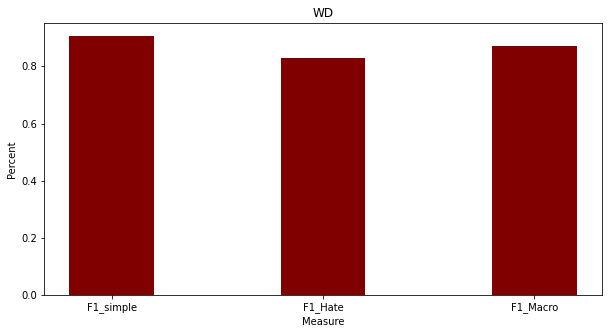

In [100]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset

  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['F1_simple','F1_Hate','F1_Macro'], [f1_simple,f1_hate,f1_macro], color ='maroon',width = 0.4)
 
plt.xlabel("Measure")
plt.ylabel("Percent")
plt.title("WD")
# plt.ylim(0, 2.0)
plt.show()